<a href="https://colab.research.google.com/github/axel-sirota/practical-nlp/blob/main/3-text-generation/Practical_NLP_8_RentalGenerator_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
!nvidia-smi

Sat Oct 15 14:15:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    48W / 400W |   2334MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [50]:
!pip install textblob 'gensim==4.2.0' 'keras-nlp'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 142 kB 4.7 MB/s 
     |████████████████████████████████| 5.9 MB 42.0 MB/s 
     |████████████████████████████████| 578.0 MB 10 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 69.4 MB/s 


In [78]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.layers.experimental import preprocessing
import keras_nlp
import os
import time
import sys
import numpy as np
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import pickle
from tensorflow.nn import leaky_relu

import re
import warnings
from sklearn.model_selection import train_test_split
from textblob import TextBlob


TRACE = False
embedding_dim = 100
rnn_units = 128
epochs=50
buffer_size = 2000
corpus_size=30000
test_corpus_size=1000
# Batch size
batch_size = 64
seq_length = 100
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [52]:
%%writefile get_data.sh
if [ ! -f train_corpus_descriptions_airbnb.csv ]; then
  wget -O train_corpus_descriptions_airbnb.csv https://www.dropbox.com/s/5rp7ibop99qyafo/train_corpus_descriptions_airbnb.csv?dl=0
fi

if [ ! -f test_corpus_descriptions_airbnb.csv ]; then
    wget -O test_corpus_descriptions_airbnb.csv https://www.dropbox.com/s/a29bbkg8hi4q4f4/test_corpus_descriptions_airbnb.csv?dl=0
fi

Overwriting get_data.sh


In [53]:
!bash get_data.sh

In [54]:
train_path = "./train_corpus_descriptions_airbnb.csv"
test_path = "./test_corpus_descriptions_airbnb.csv"
# Read, then decode for py2 compat.
airbnb_reviews = pd.read_csv(train_path, header=None, names=["review"]).dropna().sample(n=corpus_size).reset_index(drop=True)
test_airbnb_reviews = pd.read_csv(test_path, header=None, names=["review"]).dropna().sample(n=test_corpus_size).reset_index(drop=True)


In [55]:
airbnb_reviews

,review
0,"Comfortable, quiet garden-facing double room w..."
1,Welcome to the Giant Oaks House located just o...
2,The apartment is located just 2 minutes walk f...
3,Stay for 90+ nights (minimum nights and rates ...
4,"Ideal place for tourists , visiting los angele..."
...,...
29995,此房间位于罗兰岗的中心4300平方英尺独栋别墅内，小区安全，离60/57高速公路5分钟车程内...
29996,"Large 2 bedroom, 1 lounge, garden flat, Kew Ro..."
29997,Double room available in prime location in Lon...
29998,"The room is in a very nice flat, shared with t..."


In [56]:
# Take a look at the first review in text
print(airbnb_reviews.iloc[0].review)


Comfortable, quiet garden-facing double room with own en-suite (shower & toilet) on the 2nd floor of a lovely two-story 2.5 bedroom home, conveniently located in between 3 tubes stations, plenty of buses, bike hiring , walking distance to Hyde Park and canals. You are welcome to make yourself at home in all common areas including the large lounge, kitchen and communal garden as well as the study if you require a quiet work-desk.The spaceA large, bright, cozy home with extra high ceiling and full length double glazed windows, set over the ground and first floors. Comprising of a spacious carpeted lounge with leather sofas, flat screen TV, DVD player, streaming services, with large double doors opening to a comfortable eat- in kitchen with polished wooden floor and all mod cons. Free internet available on the wireless network which reaches all the way out to the quiet communal garden.The available tranquil bedroom looks out to the communal garde


In [57]:
vocab = set()

for ix, review in airbnb_reviews.iterrows():
    vocab.update(set(str(review['review'])))
vocab = sorted(vocab)

In [58]:
print(f'{len(vocab)} unique characters')


2544 unique characters


In [59]:
ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)

In [60]:
chars_from_ids = preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [61]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [62]:
ids = ids_from_chars(tf.strings.unicode_split('Only you can prevent forest fires', input_encoding='UTF-8'))
ids

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([49, 80, 78, 91,  2, 91, 81, 87,  2, 69, 67, 80,  2, 82, 84, 71, 88,
       71, 80, 86,  2, 72, 81, 84, 71, 85, 86,  2, 72, 75, 84, 71, 85])>

In [63]:
text_from_ids(ids)

<tf.Tensor: shape=(), dtype=string, numpy=b'Only you can prevent forest fires'>

In [64]:
def preprocess_text(text, should_join=True):
    text = str(text)
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [65]:
def get_ids_tensor(df):
  all_ids = tf.constant(np.zeros((1, seq_length)), dtype='int64')

  for review in df.review:
      review = preprocess_text(review)
      review_length = len(review)
      batches = review_length // seq_length
      for batch in range(batches):
        lower_limit = batch*seq_length
        upper_limit = (batch + 1)*seq_length
        value = ids_from_chars(tf.strings.unicode_split(review[lower_limit: upper_limit], 'UTF-8'))
        value = tf.reshape(value, [1, 100])
        output = tf.concat([all_ids,value], axis=0)
        all_ids = tf.reshape(output, [-1, 100])
  return all_ids[1:]

all_ids = get_ids_tensor(df=airbnb_reviews)
print(all_ids)

tf.Tensor(
[[69 81 79 ... 88 71 78]
 [91  2 86 ... 80 73  2]
 [89 67 78 ... 84 71 67]
 ...
 [80 67 78 ... 67 80 70]
 [89 67 78 ... 86 75 81]
 [80  2 86 ... 70  2 69]], shape=(181294, 100), dtype=int64)


In [66]:
ids_from_chars(tf.strings.unicode_split(airbnb_reviews.review[0][0:100], 'UTF-8'))

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([37, 81, 79, 72, 81, 84, 86, 67, 68, 78, 71, 14,  2, 83, 87, 75, 71,
       86,  2, 73, 67, 84, 70, 71, 80, 15, 72, 67, 69, 75, 80, 73,  2, 70,
       81, 87, 68, 78, 71,  2, 84, 81, 81, 79,  2, 89, 75, 86, 74,  2, 81,
       89, 80,  2, 71, 80, 15, 85, 87, 75, 86, 71,  2, 10, 85, 74, 81, 89,
       71, 84,  2,  8,  2, 86, 81, 75, 78, 71, 86, 11,  2, 81, 80,  2, 86,
       74, 71,  2, 20, 80, 70,  2, 72, 78, 81, 81, 84,  2, 81, 72])>

In [67]:
test_all_ids = get_ids_tensor(df=test_airbnb_reviews)

In [68]:
#Prepare the dataset
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
test_ids_dataset = tf.data.Dataset.from_tensor_slices(test_all_ids)

In [69]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [70]:
dataset = ids_dataset.map(split_input_target)
test_dataset = test_ids_dataset.map(split_input_target)


In [71]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'comfortable quiet garden facing double room with own en suite shower toilet on the nd floor of love'
Target: b'omfortable quiet garden facing double room with own en suite shower toilet on the nd floor of lovel'


In [72]:
dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)
test_dataset = (
    test_dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)

In [73]:
class RentalGenerator(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.GRU(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [74]:
model = RentalGenerator(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [75]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 99, 2545) # (batch_size, sequence_length, vocab_size)


In [76]:
model.summary()

Model: "rental_generator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  254500    
                                                                 
 gru_2 (GRU)                 multiple                  88320     
                                                                 
 dense_2 (Dense)             multiple                  328305    
                                                                 
Total params: 671,125
Trainable params: 671,125
Non-trainable params: 0
_________________________________________________________________


In [79]:
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, mask_token_id=0)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[perplexity])

In [80]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.05)
history = model.fit(dataset, epochs=epochs, validation_data=test_dataset, workers=5, callbacks=[callback])

Epoch 1/50
2832/2832 [==============================] - 31s 10ms/step - loss: 2.7347 - perplexity: 15.4048 - val_loss: 2.1453 - val_perplexity: 8.5449
Epoch 2/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.8396 - perplexity: 6.2940 - val_loss: 1.6590 - val_perplexity: 5.2541
Epoch 3/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.5607 - perplexity: 4.7620 - val_loss: 1.4972 - val_perplexity: 4.4690
Epoch 4/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.4564 - perplexity: 4.2907 - val_loss: 1.4307 - val_perplexity: 4.1816
Epoch 5/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.3981 - perplexity: 4.0474 - val_loss: 1.3835 - val_perplexity: 3.9888
Epoch 6/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.3561 - perplexity: 3.8808 - val_loss: 1.3459 - val_perplexity: 3.8418
Epoch 7/50
2832/2832 [==============================] - 29s 10ms/step - loss: 1.3256 - perplexity: 

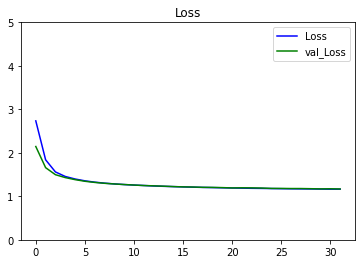

In [83]:
import matplotlib.pyplot as plt

# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], val_metric=history.history['val_loss'], metric_name="Loss", title="Loss", ylim=5.0)

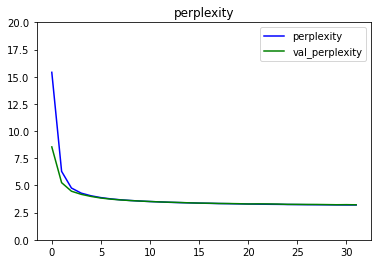

In [84]:
plot_metrics(history.history['perplexity'], val_metric=history.history['val_perplexity'], metric_name="perplexity", title="perplexity", ylim=20.0)

In [85]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [87]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Midtown Sunny 2-Bedroom'])
result = [next_char]

for n in range(250):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)



tf.Tensor([b'Midtown Sunny 2-Bedroom and kits of theer comporioth valley one stop is hobs bedrooms could ecome clean and the apartment is there is have it is it we inother to enjoy direct upstairs night on is game one pour apartment is lowhere the arrund souturan beverennets table has '], shape=(1,), dtype=string) 

________________________________________________________________________________

Run time: 1.320162296295166


In [88]:
tf.saved_model.save(one_step_model, 'rental_generator')